This notebook will detect the CF portions of calls in single and multi-bat audio. I'll be using the same audio files as used in the individual call analysis, as the idea is to use the same inputs, but a slightly different analysis method. 

The current analysis will extract CF portions of calls and measure their duration. This is a follow-up from the individual call analysis result showing that calls in multi-bat recordings had slightly shorter CF durations (by ~2.5 ms). 

Briefly, the loudest 0.5 seconds of each audio clip is first isolated. Then, the peak frequency +/- 1.5 kHz is isolated as the 'band of interest' - which contains the CF parts of one bats calls. A spectrogram representation is used to isolate the CF from other call portions. All regions within the band of interest above a threshold are considered CF parts of calls. All continuous regions above threshold are grouped - and their start/stop times are recorded. 


Author: Thejasvi Beleyur

Date of notebook initiation: 2021-05-07


In [89]:
import datetime as dt
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal 
import soundfile as sf
import numpy as np
import cf_detector as cfd
import tqdm

In [44]:
def find_CF_components(X,fs,**kwargs):
    '''
    '''
    # get loudest 0.5s
    part_X = cfd.choose_loudest_window(X,fs)
    # band of interest
    band_of_interest = cfd.get_band_of_interest(part_X, fs,**kwargs)
    # CF detections
    CF_detections, image = cfd.cf_detector(part_X,fs, band_of_interest,**kwargs)
    return CF_detections, image, band_of_interest

In [2]:
%matplotlib notebook

In [5]:
df = pd.read_csv('../individual_call_analysis/analysis/one_call_per_row_2020-12-17.csv')

In [12]:
# get all the files that need to be analysed:
audio_files = df['audio_file'].tolist()

In [83]:
filenum = 140


In [92]:
# make a directory with all CF detections in 
output_image_folder = 'cf_detection_images/'
if not os.path.isdir(output_image_folder):
    os.mkdir(output_image_folder)

In [105]:
cf_detection_datasheet = pd.DataFrame(data={},
                                      columns=['audio_file','cf_detection_number','detection_start','detection_stop'])
cf_detection_datasheet

,audio_file,cf_detection_number,detection_start,detection_stop


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


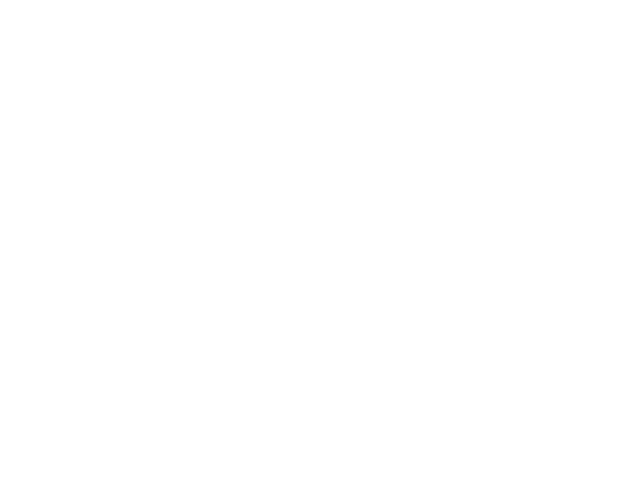

 10%|████████▎                                                                          | 1/10 [00:01<00:10,  1.12s/it]

<IPython.core.display.Javascript object>


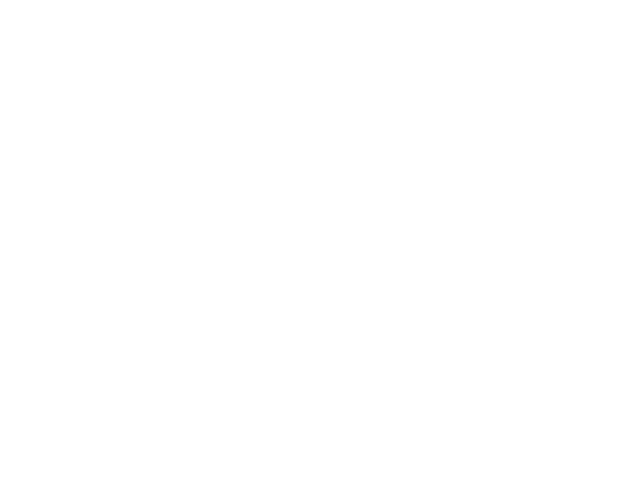

 20%|████████████████▌                                                                  | 2/10 [00:02<00:09,  1.15s/it]

<IPython.core.display.Javascript object>


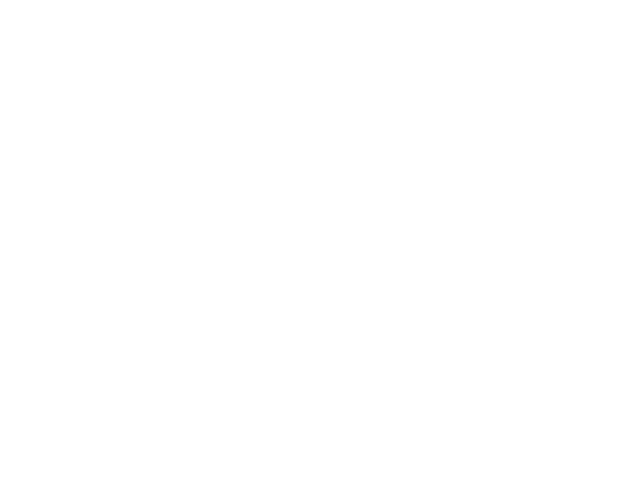

 30%|████████████████████████▉                                                          | 3/10 [00:03<00:07,  1.10s/it]

<IPython.core.display.Javascript object>


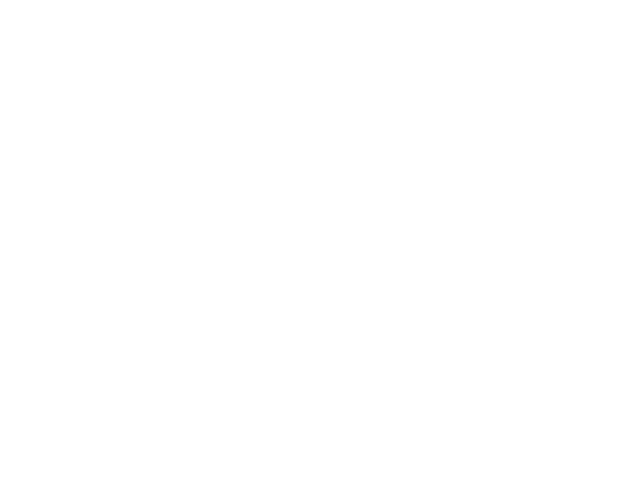

 40%|█████████████████████████████████▏                                                 | 4/10 [00:04<00:06,  1.13s/it]

<IPython.core.display.Javascript object>


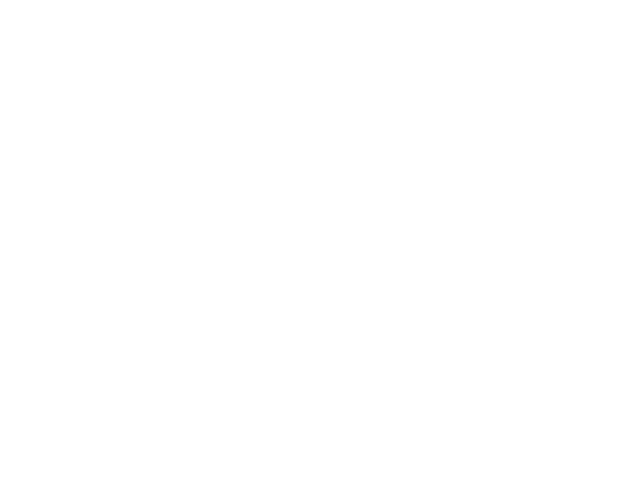

 50%|█████████████████████████████████████████▌                                         | 5/10 [00:05<00:05,  1.14s/it]

<IPython.core.display.Javascript object>


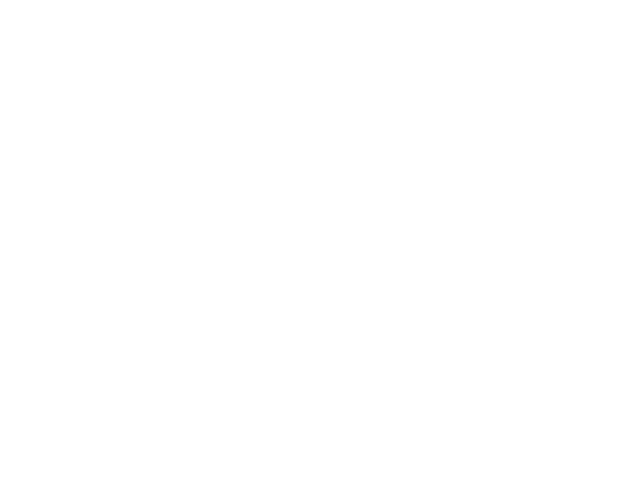

 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:06<00:04,  1.12s/it]

<IPython.core.display.Javascript object>


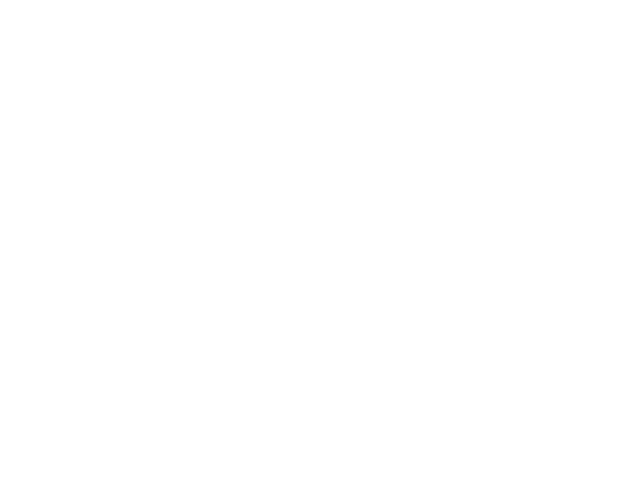

 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:07<00:03,  1.14s/it]

<IPython.core.display.Javascript object>


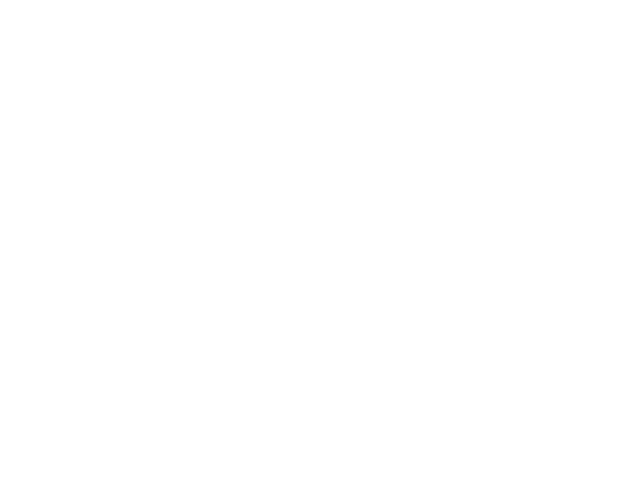

 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [00:09<00:02,  1.13s/it]

<IPython.core.display.Javascript object>


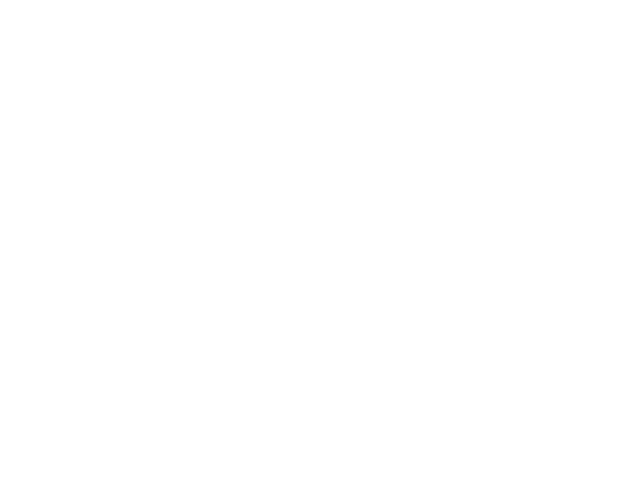

 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:10<00:01,  1.15s/it]

<IPython.core.display.Javascript object>


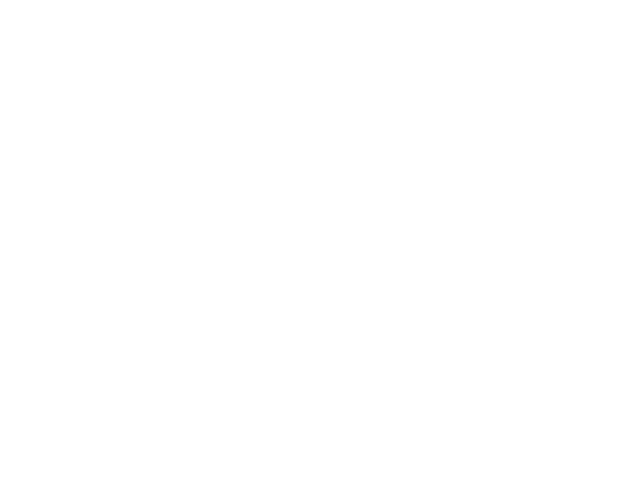

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


In [111]:
all_detections = []
for each in tqdm.tqdm(audio_files):
    cf_detection_datasheet = pd.DataFrame(data={},
                                      columns=['audio_file','cf_detection_number','detection_start','detection_stop'])

    original_audiofile = '_'.join(each.split('_')[1:])
    audio_folder = '../individual_call_analysis/hp_annotation_audio/'
    all_available_files = glob.glob(audio_folder + "/**/*.wav", recursive = True)
    filepath  = [each for each in all_available_files if original_audiofile in each][0]
    audio, fs = sf.read(filepath)
    ch0 = audio[:,0]
    cf_detections, image, band_ofinterest = find_CF_components(ch0, fs)
    for i,each in enumerate(cf_detections):
        plt.hlines(list(band_ofinterest), each[0].start/fs, each[0].stop/fs)
        plt.text(np.mean([each[0].start, each[0].stop])/fs,band_ofinterest[1],str(i))
    plt.title(f'{original_audiofile}')
    # plt.savefig(os.path.join(output_image_folder, f'{original_audiofile}.png'))
    plt.close()
    
    cf_detection_datasheet['cf_detection_number'] = range(len(cf_detections))
    cf_detection_datasheet['audio_file'] = original_audiofile
    cf_detection_datasheet['detection_start'] =  [each[0].start/fs for each in cf_detections]
    cf_detection_datasheet['detection_stop'] =  [each[0].stop/fs for each in cf_detections]
    all_detections.append(cf_detection_datasheet)

final_cf_detections = pd.concat(all_detections)
final_cf_detections.to_csv('cf_detection_data.csv')

## Manual inspection step
I will now go through each of the output CF detections and verify which ones are reliable. Let's begin by creating a data entry sheet where I can enter the reliable detection IDs. 

In [118]:
# make DF with all audio files with at elast one CF detection:
manual_verification_df = pd.DataFrame()
manual_verification_df['audio_file'] = pd.unique(final_cf_detections.loc[:,'audio_file'])
manual_verification_df['detections_to_keep'] = np.nan
manual_verification_df

,audio_file,detections_to_keep
0,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN
1,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN
2,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN
3,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN
4,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN
5,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN
6,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN
7,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN
8,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN
9,matching_annotaudio_Aditya_2018-08-16_21502300...,NaN


In [136]:
timestamp = dt.datetime.strftime(dt.datetime.now(),'%Y-%m-%d_%H-%M')
print(timestamp)

2021-07-05_17-20


In [137]:
manual_verification_df.to_csv(f'manual_verif_{timestamp}_creationtime.csv')